In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramzitalhouk","key":"5930ddaf8c75d7d8d5a6223bc31ab140"}'}

In [5]:
! cp ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download grassknoted/asl-alphabet

100% 1.02G/1.03G [00:15<00:00, 65.2MB/s]
100% 1.03G/1.03G [00:15<00:00, 73.2MB/s]


In [6]:
! unzip asl-alphabet.zip -d asl_alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet/asl_alphabet_train/asl_alp

In [8]:
from keras import layers, Sequential, metrics
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time
import pathlib
from typing import Tuple, Any, Optional


def load_image_dataset(image_dir, batch_size, img_height, img_width) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    data_dir = pathlib.Path(image_dir)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    
    return train_ds, val_ds


def fit_cnn(train_ds: tf.data.Dataset, val_ds: tf.data.Dataset) -> Tuple[
    Sequential, Any]:
    start = time.time()
    data_augmentation = Sequential(
        [
         layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                      input_shape=(80, 
                                                                   80,
                                                                   3)),
         layers.experimental.preprocessing.RandomRotation(0.1),
         layers.experimental.preprocessing.RandomZoom(0.1),
         ])
    model = Sequential([
                        data_augmentation,
                        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80, 80, 3)),
                        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(80, 80, 3), padding="same"),
                        layers.MaxPooling2D(),
                        layers.Dropout(0.1),
                        layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
                        layers.MaxPooling2D(),
                        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
                        layers.Dropout(0.2),
                        layers.Flatten(),
                        layers.Dense(64, activation='relu'),
                        layers.Dense(29)
                        ])
    model.compile(optimizer='adam',
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    history = model.fit(train_ds, epochs=50,
                        validation_data=val_ds)
    model.save("./drive/MyDrive/model3")
    print("CNN fit finished in:", (time.time() - start) / 3600, "hours")
    print("Model Summmary:", model.summary())
    return model, history


def evaluate_cnn(history) -> None:
    start = time.time()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(50)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    print("CNN scoring finished in:", time.time() - start, "seconds")

def train_cnn_model() -> None:
    train_ds, val_ds = load_image_dataset("/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/", 32, 80, 80)
    # x_test, y_test = load_image_dataset("./images/asl_alphabet_test/asl_alphabet_test/")
    # TODO: Get train/test data
    # x_test = scale_data(x_test)
    model, metrics = fit_cnn(train_ds, val_ds)
    report = score(model, val_ds)
    graph_report(report)
    evaluate_cnn(metrics)

In [34]:
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image_dataset_from_directory
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.nn import softmax
import numpy as np
import tensorflow_datasets as tfds

letters = [chr(i) for i in range(ord("A"), ord("Z") + 1)]
letters.insert(4, "del")
letters.insert(15, "nothing")
letters.insert(21, "space")

letter_map = {i: letter for i, letter in enumerate(letters)}

def score(model, test_data) -> Tuple[dict, np.array]:
    target = None
    preds = None
    for image_batch, label_batch in tfds.as_numpy(test_data):
      if target is None:
        target = label_batch
      else:
        target = np.append(target, label_batch)
      predictions = model.predict(image_batch)
      classes = []
      for p in predictions:
        score = softmax(p)
        classes.append(np.argmax(score))
      if preds is None:
        preds = np.array(classes)
      else:
        preds = np.append(preds, np.array(classes))

    pred = pd.Series(preds).replace(letter_map)
    print(pred)
    target = pd.Series(target).replace(letter_map)
    report = classification_report(target, pred, output_dict=True)
    conf_matrix = confusion_matrix(target, pred)
    return report, conf_matrix
    

def graph_report(report):
    data = pd.DataFrame(columns=["letter", "score", "type"])
    for letter in letters:
        precision = report[letter]["precision"]
        recall = report[letter]["recall"]
        f1 = 2 * (precision * recall) / (precision + recall)
        data = data.append({"letter": letter,
                            "score": precision,
                            "type": "precision"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": recall,
                            "type": "recall"}, ignore_index=True)
        data = data.append({"letter": letter,
                            "score": f1,
                            "type": "F1 score"}, ignore_index=True)
    sns.barplot(data=data, x="letter", y="score", hue="type")
    plt.xticks(rotation=90)
    plt.ylim(0.9, 1)
    plt.legend(loc='lower right')
    plt.show()

def load_test_dataset(image_dir, batch_size, img_height, img_width) -> tf.data.Dataset:
    data_dir = pathlib.Path(image_dir)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int')
    return val_ds

def score_loaded_model():
  val_ds = load_test_dataset("/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train/", 32, 80, 80)
  model = load_model("./drive/MyDrive/model2/")
  report, conf_matrix = score(model, val_ds)
  print(f"Confusion Matrix:\n{conf_matrix}")
  graph_report(report)


In [9]:
train_cnn_model()

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Epoch 1/50


ValueError: ignored

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
0          S
1        del
2          T
3          I
4          H
        ... 
17395      P
17396      O
17397      C
17398      L
17399      Y
Length: 17400, dtype: object
Confusion Matrix:
[[622   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11   0
    0   0   0   0   0   0   0   0   1   0   0]
 [  1 591   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    6   0   2   0   0   0   0   0   0   0   1]
 [  0   0 598   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 617   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   2   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0 592   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 596   2   3   3   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0]
 [  0  

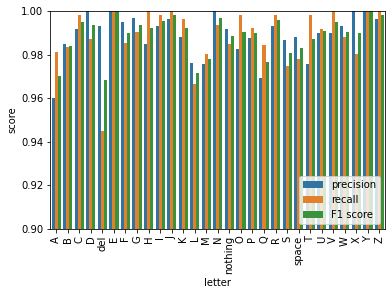

In [35]:
score_loaded_model()